## 이 노드의 루브릭               

1. 시계열의 안정성이 충분히 확인되었는가? >> 플로팅과 adfuller 메소드가 모두 적절히 사용되었음            
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? >> p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨          
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? >> 3개 이상의 종목이 MAPE 10% 미만의 정확도로 예측됨

## 목차       

__1. 시계열 데이터 준비__           
- 칼럼 종류 7개(Date, Open, High, Close, Adj Close, Volume) 중 Close(종가)만 활용하여 예측한다.               

__2. 각종 전처리 수행__  
- 결측치 처리        
- 로그 변환      

__3. 시계열 안정성 분석__      
- 정성적 그래프 분석    
- 정량적 그래프 분석(Augmented Dicky-Fuller Test)     
- 시계열 분해(Time Series Decomposition)        
- Residual 안정성 확인           

__4. 학습, 테스트 데이터셋 생성__        
- 학습, 테스트에 대한 데이터셋 분리          

__5. 적정한 ARIMA 모수 찾기__        
- ACF, PACF 그려보기 -> p,q 정하기        
- 차분 안정성 확인 -> d 구하기      

__6. ARIMA 모델 훈련과 테스트__        
- ARIMA 모델 빌드와 훈련       
- 모델 테스트 및 플로팅      
- 최종 예측 모델 정확도 측정(MAPE)        

__7. 다른 주식 종목 예측해보기__        
- 관심 종목을 골라 위 스텝 1~6을 반복해 보기

## 1. 시계열 데이터 준비               

### 데이터셋 로드

In [1]:
#필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt     
import os

print('라이브러리 임포트 완료')

라이브러리 임포트 완료


In [17]:
dataset_file = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex13_Arima/SamsungData/samsung_history.csv'

dataframe = pd.read_csv(dataset_file)
dataframe.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


> - 이 중에서, 필요한 데이터인 Date, Close만 Serise 데이터로 남긴다. 

In [18]:
df1 = pd.read_csv(dataset_file, index_col='Date', parse_dates=True)

df1.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [19]:
#index=date, 필요한 데이터=Close만 남긴 변수 samsung_close를 dataFrame 형으로 생성
samsung_close = df1.loc[:, ['Close']]

samsung_close.head(5)

,Close
Date,
2000-01-04,6110.0
2000-01-05,5580.0
2000-01-06,5620.0
2000-01-07,5540.0
2000-01-10,5770.0


In [20]:
#이를 Series로 변환 
sc = df1['Close']
print("sc의 데이터 타입 : ", type(sc))

sc.head(5)

sc의 데이터 타입 :  <class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

> - Samsung의 역대 주식 데이터 중 '종가' 만 남긴 Serise 데이터를 생성하였다.

## 2. 각종 전처리 수행                       

### 1. 결측치 처리       

- 데이터 예측에 악영향을 미칠 수 있는 결측치가 존재하는지 여부를 확인한다.       
- 이를 삭제하거나, 보간하여 대체할 수 있다.

In [21]:
#결측치가 있는 부분을 Series로 출력하도록 함
sc[sc.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

보간한 후 결측치의 숫자 :  0


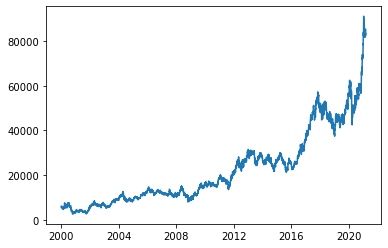

In [27]:
#총 6개의 NaN값이 나왔고, 시리즈 데이터는 연속적이어야 하므로 결측치를 드롭하기보다는 보간처리하는 것이 좀 더 적합한 방법일 것이다.
#라이브러리를 활용하여 보간처리       
#시간(Date)를 기준으로 보간한다.
sc = sc.interpolate(method='time')

print('보간한 후 결측치의 숫자 : ', len(sc[sc.isna()]))

plt.plot(sc)

> - 결측치 6개에 대한 보간처리를 완료하였다.

### 2. 로그 변환            

- 위의 그래프는 가격이 전체적으로 우상향하는 그래프이므로, 안정성을 갖춘 시계열 데이터인가의 여부를 판단하기 어렵다.        
- 이 부분을 개선하기 위해, 로그함수 값을 변환한다.

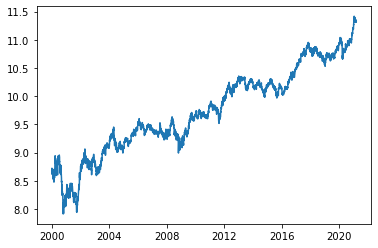

In [28]:
sc_log = np.log(sc)
plt.plot(sc_log)

### 3. Moving Average 제거, 추세(Trend) 상쇄하기        

- 시간의 흐름에 따라 나타나는 평균값 변화(추세)를 제거하기 위해서, rolling_mean을 구해서 log 변환 값에서 빼보자.

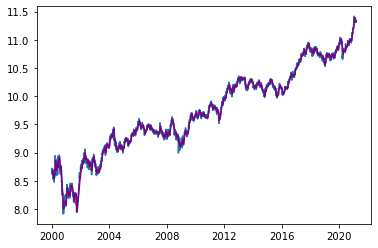

In [36]:
#평균 구하기
moving_average = sc_log.rolling(window=12).mean()
plt.plot(sc_log)
plt.plot(moving_average, color='purple')

In [37]:
#변화량을 제거
sc_log_moving_average = sc_log-moving_average
sc_log_moving_average.head(15)

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12         NaN
2000-01-13         NaN
2000-01-14         NaN
2000-01-17         NaN
2000-01-18         NaN
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
Name: Close, dtype: float64

In [39]:
#발생한 결측치들을 제거
sc_log_moving_average.dropna(inplace=True)
sc_log_moving_average.head(15)

Date
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057965
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
2000-02-01   -0.075802
2000-02-02   -0.076542
2000-02-03   -0.085232
2000-02-04   -0.072735
2000-02-07   -0.039679
2000-02-08    0.002573
Name: Close, dtype: float64

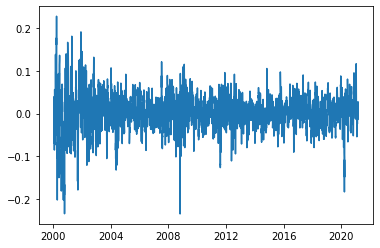

In [42]:
#추세를 제거한 그래프를 시각화
plt.plot(sc_log_moving_average)

> - 몇 가지 눈에 띄는 포인트(08년, 20년)를 제외하고, 대체적으로 그래프의 최대-최솟값 변동 및 주기가 일정해 보인다는 것을 확인할 수 있다.

### 4. 차분(Differencing)을 진행하여 계절성 상쇄하기 

- Trend에서는 잡히지 않지만, Series 안에 포함된 파악되지 않은 주기적 변화는 예측에 방해가 될 수 있다.      
- 따라서 차분(시계열을 한 스텝 앞으로 옮긴 원래 시계열에서 빼 주는 방법)을 통해, '이번 스텝에서 발생한 변화량'을 얻게 된다.

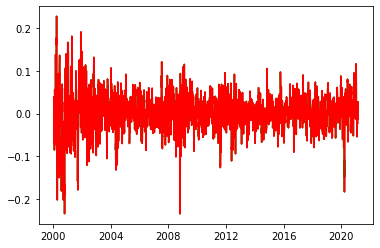

In [45]:
#시계열으로 보기
sc_log_moving_average_shift = sc_log_moving_average.shift()

#원래 그래프==blue
plt.plot(sc_log_moving_average, color='green')

#옮긴 그래프==purple
plt.plot(sc_log_moving_average_shift, color='red')

> - 너무 촘촘하게 있어서 덮어버리는 매직

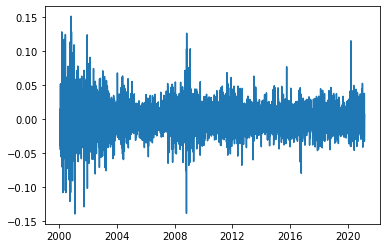

In [46]:
#차분 구하기
sc_log_moving_average_differencing = sc_log_moving_average - sc_log_moving_average_shift

#차분할 때, 결측치는 대체하여 준다
sc_log_moving_average_differencing.dropna(inplace=True)

plt.plot(sc_log_moving_average_differencing)

### 데이터 전처리 결과

1. 결측치 제거    
2. 로그 변환    
3. 추세(Trend) 상쇄         
4. 계절성(Seosonality) 상쇄       

를 통해, 시계열 데이터의 stationary를 확보하기 위한 여러가지 방법을 수행하였다.      
다음 스텝에서 이 시계열 데이터의 'Stationary'를 확인해보자.

## 3. 시계열 안정성 분석               

- 시계열 데이터의 안정성(Stationary)을 달성하려면 다음과 같은 조건이 필요하다.       
1. 시간의 추이와 관계 없이 평균이 불변       
2. 시간의 추이와 관계 없이 분산이 불변      
3. 두 시점 간의 공분산이 기준 시점과 무관(하게 동일)

- 따라서, 시계열 데이터의 예측을 위해 우리가 가져온 데이터가 위의 조건을 만족하는지 확인해야 하고,     
- 이를 위해 __정성적 그래프 분석__ 과 __정량적 그래프 분석__ 을 수행한다.

### 1. 정성적 그래프 분석                   

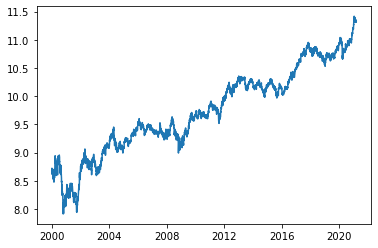

In [29]:
#그래프 분석을 진행하기 전에 현재의 그래프를 재확인
plt.plot(sc_log)

In [30]:
#일정한 시간 내의 구간 통계치를 시각화해보는 함수를 통해, 현재 시간의 입력 t와 다음 입력 t사이의 평균과 표준편차를 원본 시계열과 함께 시각화해 본다.
def plot_rolling_statics(timeseries, window=12):
    
    #이동 평균, 이동 표준편차 시계열
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    #원본, 이동평균, 이동표준편차를 plot으로 시각화
    origin = plt.plot(timeseries, color='blue', label='Original_data')
    mean = plt.plot(rolmean, color='red', label='Rolling_mean')
    std = plt.plot(rolstd, color='black', label='Rolling_std')
    
    plt.legend(loc='best')
    plt.title('Rolling Means & Standard Deviation')
    plt.show(block=False)
    
print('함수 세팅 완료')

함수 세팅 완료


> - 이 그래프의 경우, 시간과 관련한 시계열 데이터이므로 window=12로 설정하는 것이 좋아보인다.     
> - 아까 전처리를 마친 데이터를 위의 함수에 적용해본다.

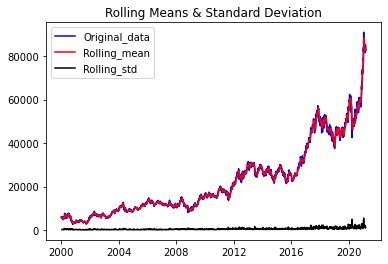

In [51]:
plot_rolling_statics(sc, window=12)

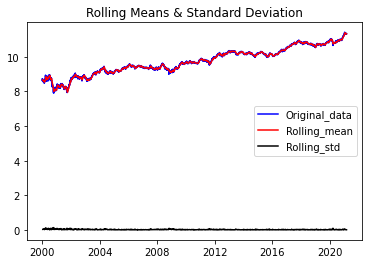

In [52]:
plot_rolling_statics(sc_log, window=12)

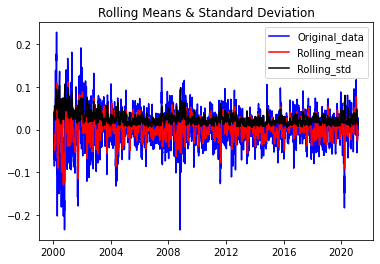

In [53]:
plot_rolling_statics(sc_log_moving_average, window=12)

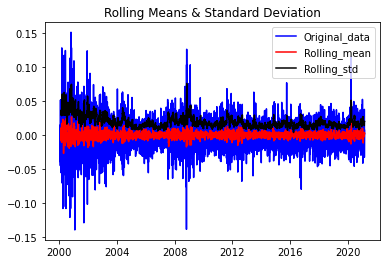

In [54]:
plot_rolling_statics(sc_log_moving_average_differencing, window=12)

## 정성적 그래프 분석 결과

> - 갈수록 더 stationary한 데이터가 맞나..? 싶은데, 정성적 테스트로는 정확히 확인이 어려우니 정량적 테스트를 시도해보자.

### 2. 정량적 그래프 분석            

- 위와 같이 정성적 그래프 분석을 통해 시계열 데이터가 stationary한 데이터일 것임을 확인했지만,         
- 통계적인 방법(정량적 분석)을 통해 이 시계열 데이터의 stationary를 한 번 더 확인해본다.      

### Augmented Dickey-Fuller Test(ADF Test)            

- '주어진 시계열 데이터가 Non-stationary 하다.' 라는 귀무가설을 세운 후 통계적 가설 검정을 통해 이 가설을 채택할지/기각할지를 정한다.    
- 특히, 이 방법에서는 p-value의 수치가 중요하다.   

In [34]:
#강력한 통계 패키지인 statmodels 패키지를 설치
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    
    #통계 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test : ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
        
    print(dfoutput)
    
print('함수 세팅 완료')

함수 세팅 완료


In [56]:
#우리의 메인 시계열 데이터인 sc_log에 대한 ADF Test를 수행해본다.      

augmented_dickey_fuller_test(sc)

Results of Dickey-Fuller Test : 
Test Statics                      2.286800
p-value                           0.998947
#Lags Used                       26.000000
Number of Observations Used    5292.000000
Critical Value(1%)               -3.431586
Critical Value(5%)               -2.862086
Critical Value(10%)              -2.567061
dtype: float64


In [57]:
augmented_dickey_fuller_test(sc_log)

Results of Dickey-Fuller Test : 
Test Statics                     -0.311819
p-value                           0.923814
#Lags Used                        4.000000
Number of Observations Used    5314.000000
Critical Value(1%)               -3.431581
Critical Value(5%)               -2.862084
Critical Value(10%)              -2.567060
dtype: float64


In [58]:
augmented_dickey_fuller_test(sc_log_moving_average)

Results of Dickey-Fuller Test : 
Test Statics                  -1.664851e+01
p-value                        1.611630e-29
#Lags Used                     1.100000e+01
Number of Observations Used    5.296000e+03
Critical Value(1%)            -3.431585e+00
Critical Value(5%)            -2.862086e+00
Critical Value(10%)           -2.567061e+00
dtype: float64


In [59]:
augmented_dickey_fuller_test(sc_log_moving_average_differencing)

Results of Dickey-Fuller Test : 
Test Statics                    -19.800806
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5273.000000
Critical Value(1%)               -3.431591
Critical Value(5%)               -2.862088
Critical Value(10%)              -2.567062
dtype: float64


> - p-value에 주목하여 보았을 때, sc -> sc_log -> sc_log_moving_average -> sc_log_moving_average_diffecing 을 지나오며  
> - p-value가 0이 된 것을 확인할 수 있다.(그런데 왜 sc_log_moving_average에서 -24.6191354568 였던 것일까...)

### 3. 시계열 분해(Time Series Decomposition)         

- 위에서는 sc_log 시리즈 데이터에 직접 trend와 seasonality를 제거하는 작업을 적용했지만, 이번에는
- statsmodels 라이브러리를 통해 sc_log에서 trend와 seasonality를 상쇄하고 안정적 시계열을 분리해보자.

In [70]:
#라이브러리 임포트
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sc_log, period=12)

print("임포트 및 적용 완료")

임포트 및 적용 완료


In [71]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print(trend)

Date
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
2000-01-10   NaN
              ..
2021-02-23   NaN
2021-02-24   NaN
2021-02-25   NaN
2021-02-26   NaN
2021-03-02   NaN
Name: trend, Length: 5319, dtype: float64


/home/ssac23/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


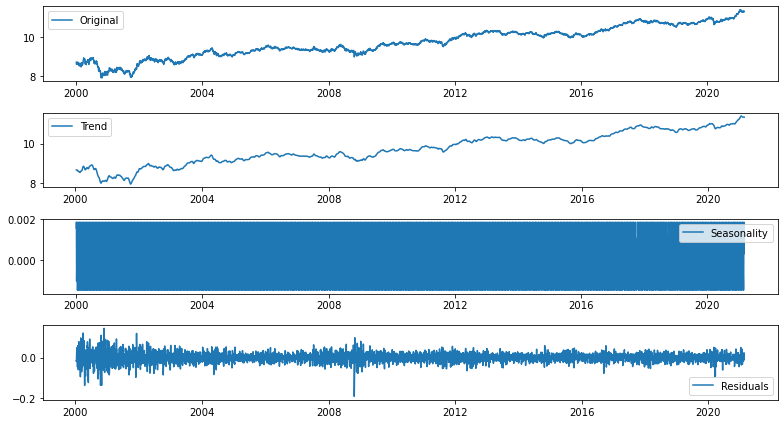

In [72]:
plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(sc_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

### 4. Residual 안정성 확인 

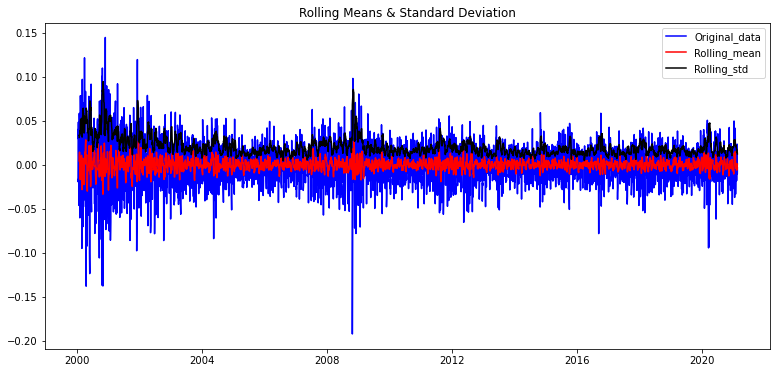

In [68]:
#시계열을 분해하고 난 Residual을 통해 안정성 여부를 따져보자.
plt.rcParams["figure.figsize"]=(13,6)
plot_rolling_statics(residual, window=12)

In [69]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test : 
Test Statics                    -20.103755
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5273.000000
Critical Value(1%)               -3.431591
Critical Value(5%)               -2.862088
Critical Value(10%)              -2.567062
dtype: float64
